In [1]:
import numpy as np, pandas as pd
import os, sys, time, pickle, copy, h5py
import lifelines.utils
import pandas as pd
import optunity
import numpy as np, pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split,StratifiedShuffleSplit
import operator as op
import itertools as it
from sklearn.preprocessing import StandardScaler



In [2]:
def coxreg_single_run(xtr, ytr, penalty):
    '''
    xtr: training data, shape (n_samples, n_features)
    ytr: training label, shape (n_samples, 2), 1st column is status, 2nd column is time
    penalty: penalizer for Cox regression
    
    '''
    df_tr = pd.DataFrame(np.concatenate((ytr, xtr),axis=1))
    df_tr.columns = ['status','time'] + ['X'+str(i+1) for i in range(xtr.shape[1])]
    cph = CoxPHFitter(penalizer=penalty)
    cph.fit(df_tr, duration_col='time', event_col='status')
    
    return cph,df_tr

In [3]:
## use cross validation to select the best penalizer
# 2. 'Hyperparameter' search for Cox Regression model
import optunity

def hypersearch_cox(x_train, y_train, x_test, y_test, method, nfolds, nevals, penalty_range):
    # strata_labels = [list(zip(*g))[0]for _, g in it.groupby(enumerate(y_data[:,0]), op.itemgetter(1))]
    # @optunity.cross_validated(x=x_data, y=y_data, num_folds=nfolds, num_iter=2, strata=strata_labels)
    x_train = x_train
    y_train = y_train
    x_test = x_test
    y_test = y_test
    def modelrun(penalty):
        cvmod,df_tr = coxreg_single_run(xtr=x_train, ytr=y_train, penalty=10 ** penalty)
        cv_preds = cvmod.predict_partial_hazard(x_test)
        cv_C = concordance_index(y_test[:, 1], -cv_preds, y_test[:, 0])
        return cv_C
    optimal_pars, searchlog, _ = optunity.maximize(modelrun, num_evals=nevals,
                                                   solver_name=method, penalty=penalty_range)
    print('Optimal hyperparameters : ' + str(optimal_pars))
    print('Cross-validated C after tuning: %1.3f' % searchlog.optimum)
    return optimal_pars, searchlog

In [18]:
data_dir = "/Data/engs2522/ECG_data/MI_to_HF_survival_data" 
df = pd.read_csv(os.path.join(data_dir, "ecg_biomarker_15_columns.csv"))

## for all trues convert it to 1
df = df.applymap(lambda x: 1 if x == True else x)
## for all false convert it to 0
df = df.applymap(lambda x: 0 if x == False else x)
features =  df.iloc[:, 1:].values
print(features.shape)
## normalize the features
first_scalar_features = StandardScaler().fit_transform(features[:,[0]])
features[:,[0]] = first_scalar_features
df.iloc[:,1] = first_scalar_features[:,0]
y_status_duration  = np.load(os.path.join(data_dir, "y_status_duration.npy"))
y_status_duration [:,1]= y_status_duration [:,1]/30.0
print(features.shape, y_status_duration.shape)
n_folds =2
seed_list = [42, 2021, 2022, 2023, 2024]



## find those patients who have follow-up time less than 48 month (4 years)
# ## and remove them from the dataset
idx  = np.where((y_status_duration[:,0]==0)&(y_status_duration [:,1] < 24))[0]
print("number of patients with follow-up time less than 48 months: ", len(idx))
## remove those patients from the dataset
features = np.delete(features, idx, axis=0)
y_status_duration = np.delete(y_status_duration, idx, axis=0)
print(features.shape, y_status_duration.shape)
print ("median follow-up time: ", np.median(y_status_duration [:,1]))
print ("max follow-up time: ", np.max(y_status_duration [:,1]))
df.head()
# df.head()

(800, 15)
(800, 15) (800, 3)
number of patients with follow-up time less than 48 months:  0
(800, 15) (800, 3)
median follow-up time:  53.0
max follow-up time:  83


,eid,VentricularRate,P-wave duration>120ms,PRInterval>200ms,QRS duration>100ms,prolonged QT interval,abnormal p axis,left axis deviation,right axis deviation,abnormal QRS-T angle,Right bundle branch block,Left bundle branch block,LVH,Low voltage,ST-T abnormality,delayed IDtime
0,1007100,2.121510,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1011223,-0.788204,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1013662,-0.506619,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,1025631,0.056552,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1028018,0.056552,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [19]:
## split the data into training and testing
import copy

cval_average_score_list = []
best_cph = None
best_C_app =0
seed_list = [42, 2021, 2022, 2023, 2024]
seed_y_score_list = []
for random_seed in seed_list:        
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    # Initialize lists to store predictions
    val_c_index_list = []
    x = features
    y = y_status_duration
    y_status_list = y[:,0]
    i =0
    average_score = []
    pred_risk_score = []
    test_indices_list = []
    for cval, (train_indices, test_indices) in enumerate(kf.split(x, y_status_list)):
        test_indices_list.append(test_indices)
        ## split the train into train and validation
        sub_train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=random_seed,stratify=y_status_list[train_indices])
        opars, osummary = hypersearch_cox(features[sub_train_indices], y_status_duration[sub_train_indices,:2], 
                                            features[val_indices], y_status_duration[val_indices,:2],
                        method="particle swarm", nfolds=n_folds, nevals=50, penalty_range=[-2, 5])
        cph,df_tr = coxreg_single_run(features[sub_train_indices],y_status_duration[sub_train_indices,:2],penalty=10**opars['penalty'])
        
        ## evaluate on the test set
        predfull = cph.predict_partial_hazard(features[test_indices])
        ##
        pred_risk_score.append(predfull)
        C_app = concordance_index(y[test_indices,1], -predfull, y[test_indices,0])
        if C_app>=best_C_app:
            best_cph = copy.deepcopy(cph)
            best_C_app = C_app
        print('\n\n==================================================')
        print(f'CV test {random_seed}:{cval}, Apparent concordance index = {np.round(C_app,4)}')
        print('==================================================\n\n')
        average_score.append(C_app)
    cval_average_score  = np.mean(average_score)
    cval_average_score_list.append(cval_average_score)
    ## flatten the list
    pred_risk_score = np.concatenate(pred_risk_score)
    test_indices = np.concatenate(test_indices_list)
    pred_risk_score_sorted = pred_risk_score[np.argsort(test_indices)]
    ## reorder the risk scores back to the original order
    ## get the indices of the test set
    seed_y_score_list.append(pred_risk_score_sorted)

print(f"for {len(seed_list)}, the average C-index",np.mean(cval_average_score_list))
print(f"for {len(seed_list)}, the std C-index",np.std(cval_average_score_list))



Optimal hyperparameters : {'penalty': 3.32861328125}
Cross-validated C after tuning: 0.868


CV test 42:0, Apparent concordance index = 0.5014


Optimal hyperparameters : {'penalty': 2.798828125}
Cross-validated C after tuning: 0.848


CV test 42:1, Apparent concordance index = 0.5329


Optimal hyperparameters : {'penalty': -1.8736762083101368}
Cross-validated C after tuning: 0.693


CV test 2021:0, Apparent concordance index = 0.62


Optimal hyperparameters : {'penalty': -1.5801367187499995}
Cross-validated C after tuning: 0.564


CV test 2021:1, Apparent concordance index = 0.433




/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column X8 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status'].astype(bool)
>>> print(df.loc[events, 'X8'].var())
>>> print(df.loc[~events, 'X8'].var())

A very low variance means that the column X8 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html

Optimal hyperparameters : {'penalty': -1.7041406249999997}
Cross-validated C after tuning: 0.604


CV test 2022:0, Apparent concordance index = 0.5603


Optimal hyperparameters : {'penalty': -1.7311717615672433}
Cross-validated C after tuning: 0.648


CV test 2022:1, Apparent concordance index = 0.4822


Optimal hyperparameters : {'penalty': -1.9602240527138746}
Cross-validated C after tuning: 0.470


CV test 2023:0, Apparent concordance index = 0.5517


Optimal hyperparameters : {'penalty': -1.9707421874999997}
Cross-validated C after tuning: 0.677


CV test 2023:1, Apparent concordance index = 0.4791




/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column X8 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['status'].astype(bool)
>>> print(df.loc[events, 'X8'].var())
>>> print(df.loc[~events, 'X8'].var())

A very low variance means that the column X8 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html

Optimal hyperparameters : {'penalty': -1.749688640819859}
Cross-validated C after tuning: 0.620


CV test 2024:0, Apparent concordance index = 0.5853


Optimal hyperparameters : {'penalty': 4.99658203125}
Cross-validated C after tuning: 0.528


CV test 2024:1, Apparent concordance index = 0.658


for 5, the average C-index 0.5403764407067975
for 5, the std C-index 0.04079457829016772


In [24]:
## plot kaplan meier curve for two different groups (96 %: MI and 98%: HYP as the cutoff)
## find the cutoff risk score
mean_risk_score_list = np.mean(np.stack(seed_y_score_list), axis=0)

## find the cutoff risk score
threshold = np.quantile(mean_risk_score_list, 0.96)
print("threshold", threshold)


threshold 4.051146125326208


(0.6, 1.01)

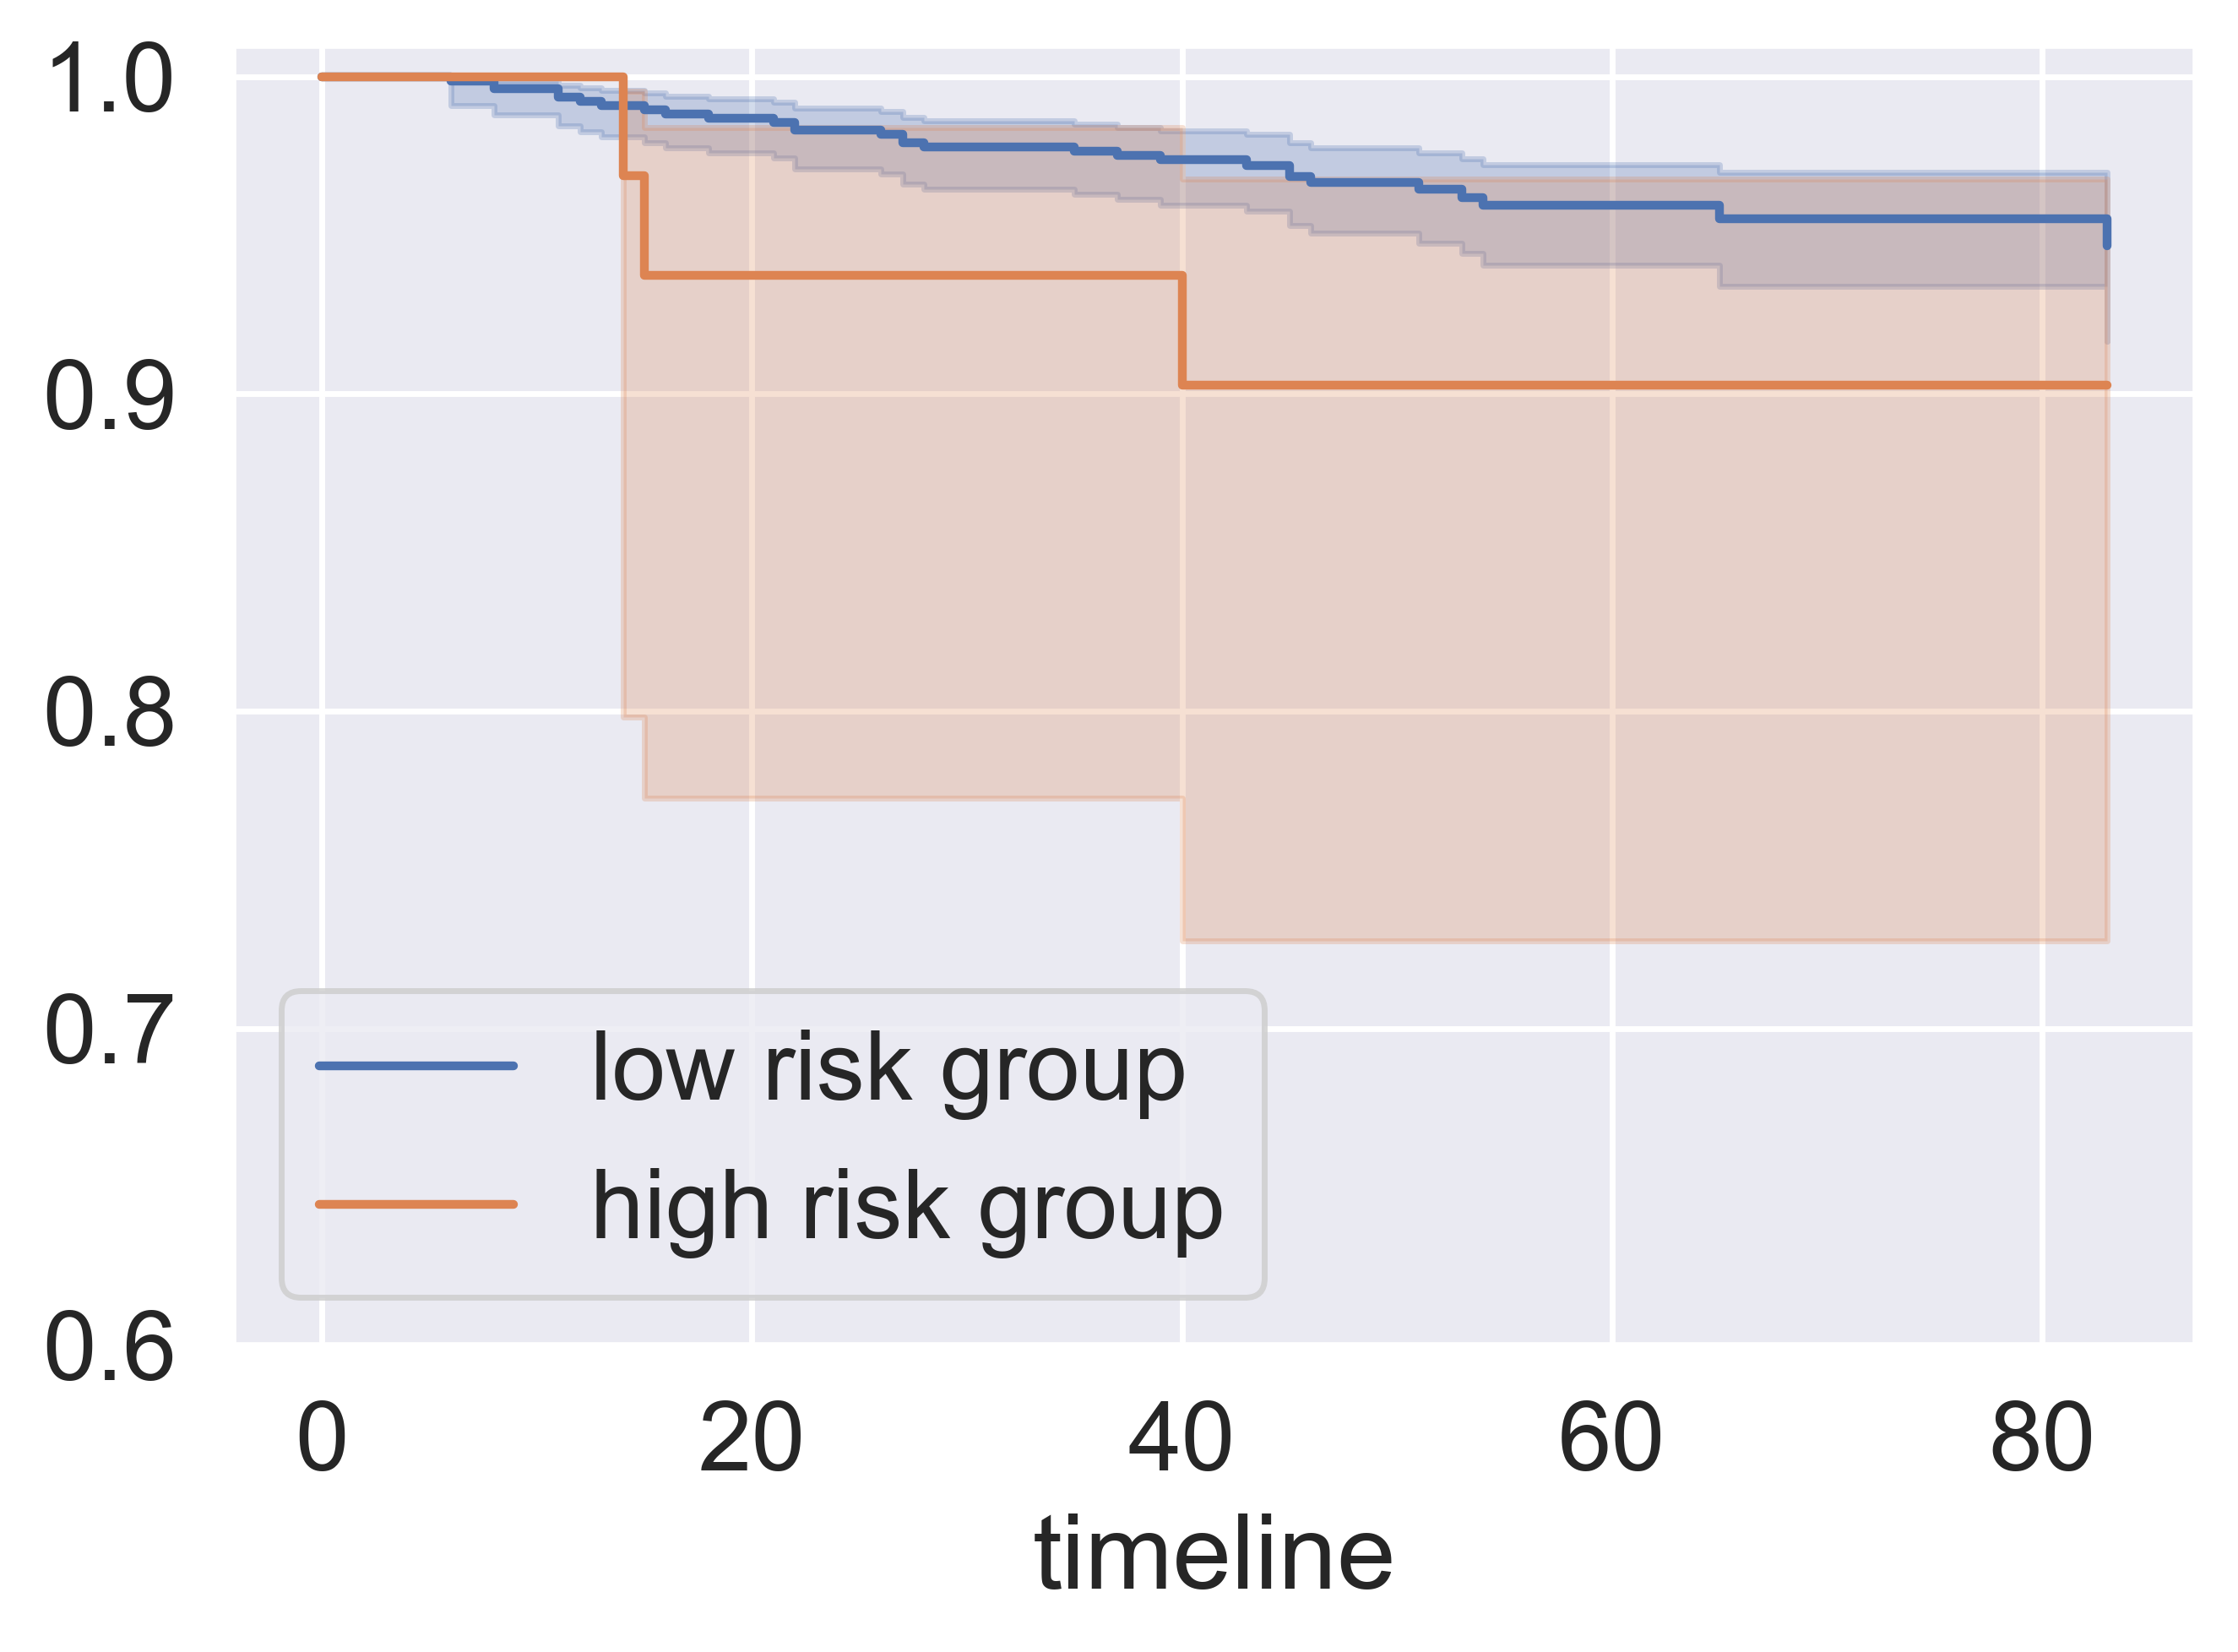

In [25]:
## plot kaplan meier curve
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5 )
low_risk_group_index = np.where(mean_risk_score_list<threshold)[0]
high_risk_group_index = np.where(mean_risk_score_list>=threshold)[0]
kmf = KaplanMeierFitter()
fig, ax  = plt.subplots(1,1,figsize=(6, 4),dpi =500)
kmf.fit(y[low_risk_group_index][:,1], event_observed=y[low_risk_group_index][:,0], label="low risk group")
kmf.plot(ax=ax)
kmf.fit(y[high_risk_group_index][:,1], event_observed=y[high_risk_group_index][:,0], label="high risk group")
kmf.plot(ax=ax)
## set the y axis limit  d
ax.set_ylim(0.60,1.01)


In [ ]:
## evaluate on the test set
predfull = best_cph.predict_partial_hazard(features)
C_app = concordance_index(y[:,1], -predfull, y[:,0])
# print('\n\n==================================================')
# print(f'CV test {random_seed}:{cval}, Apparent concordance index = {np.round(C_app,4)}')

<lifelines.CoxPHFitter: fitted with 3157 total observations, 3092 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 848.6154562084132
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3157
number of events observed = 65
   partial log-likelihood = -516.38
         time fit was run = 2023-10-12 14:08:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X1          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X2          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X3          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X4          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X5          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X6          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X7          0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
X8          0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
X9         -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
X10         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
X11         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
X12         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X13         0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
X14         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
X15         0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01

            cmp to     z    p   -log2(p)
covariate                               
X1            0.00  0.00 1.00       0.00
X2            0.00  0.01 0.99       0.01
X3            0.00  0.01 0.99       0.01
X4            0.00  0.01 0.99       0.01
X5            0.00  0.01 0.99       0.01
X6            0.00  0.01 0.99       0.01
X7            0.00  0.01 0.99       0.01
X8            0.00  0.00 1.00       0.01
X9            0.00 -0.00 1.00       0.00
X10           0.00  0.00 1.00       0.00
X11           0.00  0.02 0.99       0.02
X12           0.00  0.01 0.99       0.01
X13           0.00  0.01 1.00       0.01
X14           0.00  0.01 0.99       0.01
X15           0.00  0.02 0.98       0.03
---
Concordance = 0.68
Partial AIC = 1062.77
log-likelihood ratio test = 0.00 on 15 df
-log2(p) of ll-ratio test = -0.00

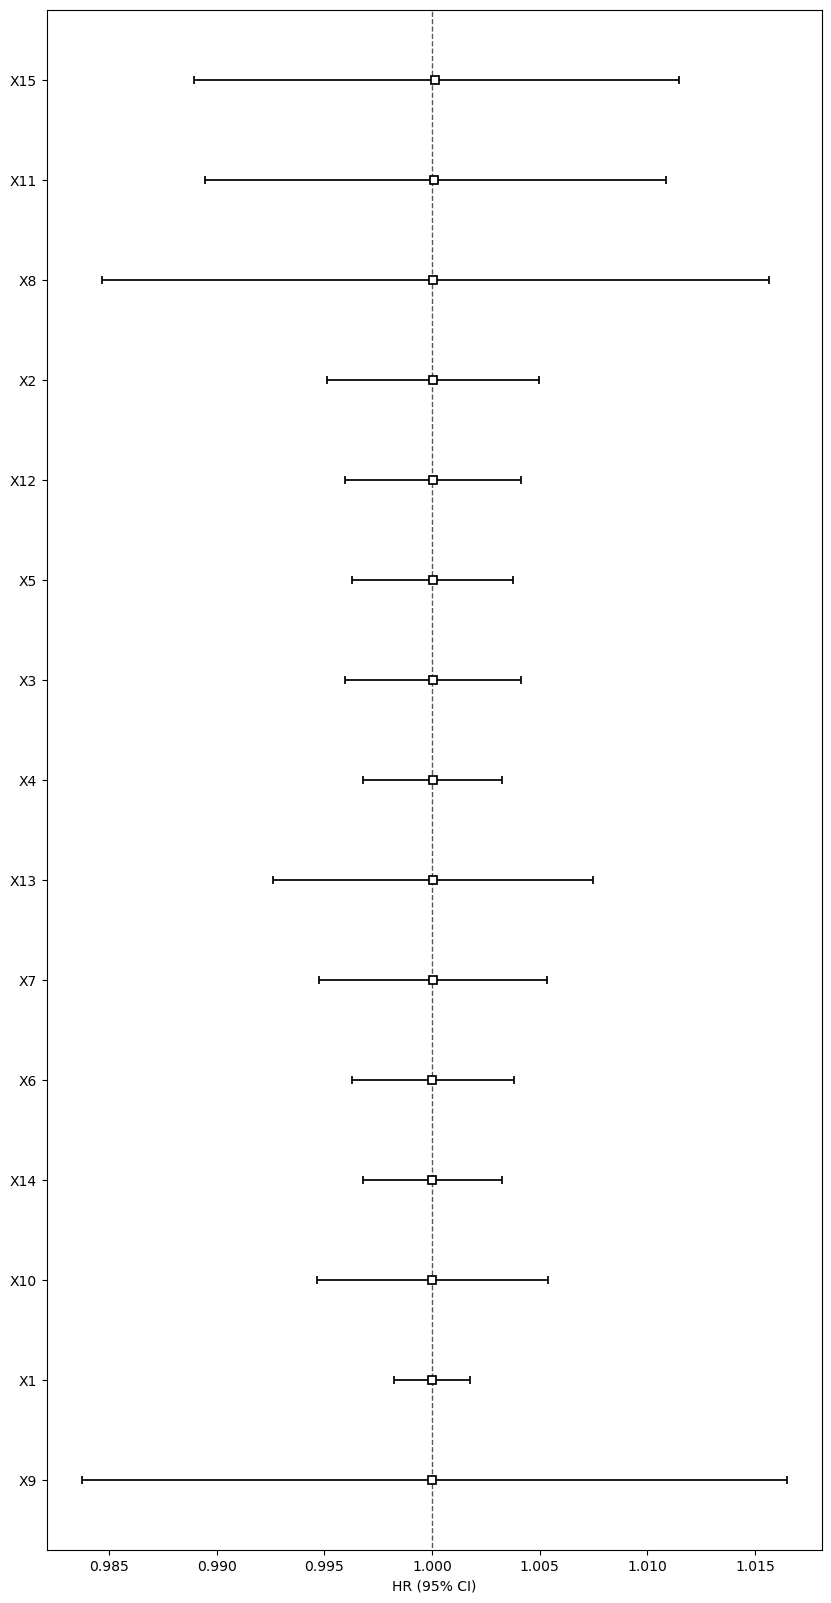

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
best_cph.plot(hazard_ratios=True)
best_cph.print_summary()
# plt.suptitle(model_name)
# plt.savefig(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/MI_HF_coxreg.png', dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'Baseline survival function')

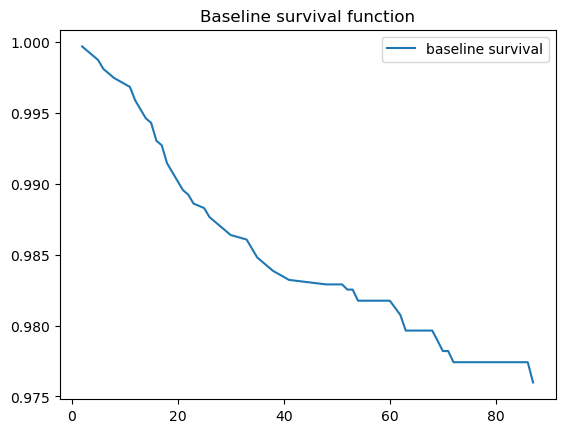

In [ ]:
# X = df.loc[0]
# cph.predict_survival_function(X).rename(columns={0:'CoxPHFitter'}).plot()
## plt baseline survival function
best_cph.baseline_survival_.plot()
plt.title('Baseline survival function')


In [ ]:
best_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4629 total observations, 4564 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.010976623042801564
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4629
number of events observed = 65
   partial log-likelihood = -518.57
         time fit was run = 2023-10-11 20:36:41 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X1          0.11       1.12       0.12            -0.13             0.35                 0.88                 1.42
X2          0.10       1.11       0.37            -0.61             0.82                 0.54                 2.28
X3          0.15       1.16       0.29            -0.42             0.72                 0.66                 2.05
X4          0.18       1.19       0.26            -0.34             0.69                 0.71                 2.00
X5          0.22       1.24       0.28            -0.32             0.76                 0.73                 2.13
X6          0.50       1.66       0.26            -0.01             1.02                 0.99                 2.77
X7         -0.09       0.91       0.41            -0.89             0.71                 0.41                 2.03
X8         -0.76       0.47       1.42            -3.55             2.02                 0.03                 7.55
X9         -0.85       0.43       1.38            -3.56             1.86                 0.03                 6.43
X10         0.41       1.51       0.40            -0.37             1.19                 0.69                 3.28
X11         1.09       2.98       0.67            -0.21             2.40                 0.81                11.01
X12         0.12       1.12       0.32            -0.50             0.74                 0.61                 2.09
X13         0.12       1.13       0.56            -0.97             1.22                 0.38                 3.38
X14         0.39       1.48       0.24            -0.09             0.87                 0.92                 2.38
X15         0.84       2.32       0.64            -0.42             2.10                 0.66                 8.17

            cmp to     z    p   -log2(p)
covariate                               
X1            0.00  0.91 0.36       1.47
X2            0.00  0.28 0.78       0.37
X3            0.00  0.52 0.61       0.72
X4            0.00  0.66 0.51       0.98
X5            0.00  0.79 0.43       1.23
X6            0.00  1.92 0.05       4.20
X7            0.00 -0.23 0.82       0.29
X8            0.00 -0.54 0.59       0.76
X9            0.00 -0.62 0.54       0.89
X10           0.00  1.03 0.30       1.72
X11           0.00  1.64 0.10       3.31
X12           0.00  0.37 0.71       0.49
X13           0.00  0.22 0.83       0.28
X14           0.00  1.60 0.11       3.19
X15           0.00  1.31 0.19       2.39
---
Concordance = 0.64
Partial AIC = 1067.15
log-likelihood ratio test = 20.93 on 15 df
-log2(p) of ll-ratio test = 2.85

X11


<AxesSubplot:>

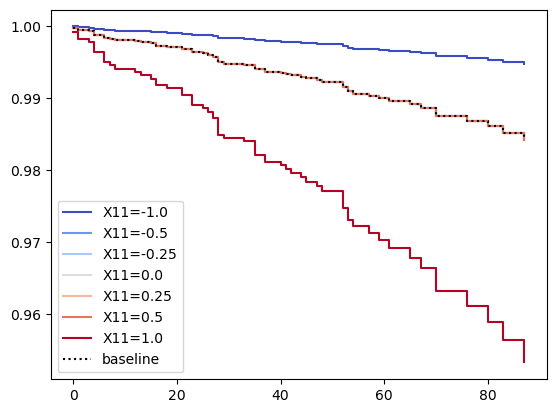

In [ ]:
## find the feature with the largest coefficient
id = best_cph.summary["coef"].sort_values(ascending=False).head(1).index.values[0]
print(id)
best_cph.plot_partial_effects_on_outcome(covariates=id, values=[-1, -0.5, -0.25,0, 0.25,0.5, 1], cmap='coolwarm')
